In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import math

In [2]:
electricity_consumption = 30 #kWh daily usage
panel_efficiency = 0.15 #%
solar_radiation = 6.0 #kWh/m2/day
degradation = 0.9 #at 10 years?
price_per_watt = 5 
electricity_consumption_percentage = 0.8
DCtoACLoss = 0.2
STC_power_rating = 260 #W
length = 1665
width = 991
warranty = 25
ElectricityPriceUCDemand = 0.15

In [3]:
#test for Unit test of SEI
electricity_consumption = 30 #kWh daily usage
panel_efficiency = 0.156 #%
solar_radiation = 5.0 #kWh/m2/day
degradation = 0.9 #at 10 years?
price_per_watt = 5.5 
electricity_consumption_percentage = 0.8
DCtoACLoss = 0.2
STC_power_rating = 260 #W
length = 1665
width = 991
warranty = 25
ElectricityPriceUCDemand = 0.2

In [6]:
def calculate_design():
   
    N_PANELS = math.ceil(electricity_consumption * electricity_consumption_percentage / \
                         ((solar_radiation) * panel_efficiency * (length * width/1000000) * ( 1 - DCtoACLoss)))
    DC_size = N_PANELS * STC_power_rating / 1000
    AC_size = DC_size * (1 - DCtoACLoss) 
    total_costs = price_per_watt * DC_size * 1000
    area = length * width / 1000000 * N_PANELS
    
    #savings over lifetime
    #current efficiency
    efficiency_t = panel_efficiency
    total_savings = 0
    AC_size_t = AC_size
    degradation_t = math.exp(math.log(degradation)/10)
    years_to_payoff = 0
    flag_years_to_payoff = False
    
    for i in range(warranty):
        #yearly production
        production_t = AC_size_t * solar_radiation * 365.25
        total_savings = total_savings + production_t * ElectricityPriceUCDemand
        AC_size_t = AC_size_t * degradation_t
        if (total_savings >= total_costs) and (not (flag_years_to_payoff)):
            flag_years_to_payoff = True
            years_to_payoff = i
            
        
        
        
    potential_costs = electricity_consumption * 365.25 * ElectricityPriceUCDemand * warranty
    percent_savings = total_savings / potential_costs
    net_savings = (total_savings - total_costs)/potential_costs
    
    
    return {'N_PANELS':N_PANELS, 'DC_size':DC_size, 'AC_size':AC_size, 'total_costs':total_costs, \
           'area':area, 'total_savings':total_savings, 'percent_savings':percent_savings, \
            'net_savings':net_savings, 'years_to_payoff': years_to_payoff}



In [7]:
design = calculate_design()
for key, value in design.items():
    print("{parameter} : {value_:8.2f}".format(parameter = key, value_ = value))

years_to_payoff :    20.00
percent_savings :     0.74
net_savings :     0.11
total_costs : 34320.00
total_savings : 40285.48
DC_size :     6.24
N_PANELS :    24.00
area :    39.60
AC_size :     4.99


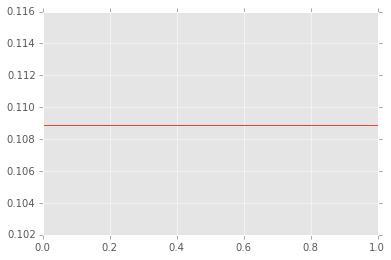

In [8]:
y = np.zeros(11)
x = np.zeros(11)
i = 0
#draw percent of a bill vs savings graph
for step in np.linspace(0.0, 1.0, num=11):
    electricity_bill_percentage = step
    #call function, get percent_savings
    design = calculate_design()
    y[i] = design['net_savings']
    x[i] = step
    i = i + 1
#draw graph
plt.plot(x, y)